# Sommaire
* [Introduction](#introduction)
* [I) Importation des données](#i)
* [II) Extraction de features](#ii)
* [III) t-SNE](#iii)
* [IV) KMeans](#iv)
* [V) Test CAH](#v)
* [VI) Synthèse des résultats](#vi)
* [Conclusion](#conclusion)

# Introduction <a class='anchor' id='introduction'></a>
Sur la marketplace e-commerce de Place de marché, les vendeurs proposent des articles en postant une photo et une description. L'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs. Pour faciliter la mise en ligne de nouveaux articles et la recherche de produits, il est nécessaire d'automatiser cette tâche d'attribution de catégorie.

Lors de ce projet, j'ai réalisé une étude de faisabilité d’un moteur de classification automatique d’articles à partir de leur image et de leur description. Focalisons nous sur les descriptions : Pour cela j’avais procédé à une extraction de features avec BERT et USE.

J'avais ensuite fait des prédictions à partir de ces features en entraînant un t-SNE pour réduire la dimensionalité, puis KMeans, et en calculant l’ARI pour mesurer la similarité entre les clusters réels et les clusters prédits.

BERT et USE ont été publiés en 2018. De nouveaux modèles ont émergés depuis, certains plus précis mais plus lourds et plus lents, et d’autres plus légers et rapides au prix d’une légère baisse de précision.

Pour ce projet, j'ai décidé de me focaliser sur une variante de BERT : RoBERTa (2019). BERT et RoBERTa existent en version de base et version large, alors je vais tester les 2.

# I) Importation des données <a class='anchor' id='i'></a>
La phase de nettoyage a été réalisée dans mon ancien notebook donc on va gagner du temps ici. On commence sur Google Colab car le GPU sera pratique pour accélérer l'extraction de features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)

Mounted at /content/drive


In [2]:
data_desc = pd.read_csv('/content/drive/MyDrive/data_desc.csv')
print('Nombre de descriptions :', len(data_desc))
data_desc.head(5)

Nombre de descriptions : 1050


uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description      categorie_1  \
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                                  description_propre  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel 3 ba...   
2  key features eurospa cotton terry face towel s...   
3  key features santosh royal fashion cotton prin...   
4  key features jaipur print cotton floral king s...   

                                   description_token  \
0  ['key', 'features', 'elegance', 'polyester', '...   
1  ['specifications', 'sathiyas', 'cotton', 'bath...   
2  ['key', 'features', 'eurospa', 'cotton', 'terr...   
3  ['key', 'features', 'santosh', 'royal', 'fashi...   
4  ['key', 'features', 'jaipur', 'print', 'cotton...   

                                    description_stem  \
0  ['key', 'featur', 'eleg', 'polyest', 'multicol...   
1  ['specif', 'sathiya', 'cotton', 'bath', 'towel...   
2  ['key', 'featur', 'eurospa', 'cotton', 'terri'...   
3  ['key', 'featur', 'santosh', 'royal', 'fashion...   
4  ['key', 'featur', 'jaipur', 'print', 'cotton',...   

                                     description_lem  \
0  ['key', 'feature', 'elegance', 'polyester', 'm...   
1  ['specification', 'sathiyas', 'cotton', 'bath'...   
2  ['key', 'feature', 'eurospa', 'cotton', 'terry...   
3  ['key', 'feature', 'santosh', 'royal', 'fashio...   
4  ['key', 'feature', 'jaipur', 'print', 'cotton'...   

                                   description_final  
0  ['key', 'elegance', 'polyester', 'multicolor',...  
1  ['specification', 'cotton', 'bath', 'towel', '...  
2  ['key', 'cotton', 'terry', 'face', 'towel', 's...  
3  ['key', 'royal', 'fashion', 'cotton', 'printed...  
4  ['key', 'jaipur', 'print', 'cotton', 'floral',...

# II) Extractions de features <a class='anchor' id='ii'></a>
Les modèles que nous allons tester ont leur propre tokenizer, et capturent le contexte global. On extrait donc les features à partir des descriptions nettoyées.

In [3]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [4]:
#On vérifie si un GPU est disponible
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
import time
from datetime import timedelta
import gc

#Dictionnaire des modèles et tokenizers à tester
models = {'BERT_base': ('bert-base-uncased', BertTokenizer, BertModel),
          'BERT_large': ('bert-large-uncased', BertTokenizer, BertModel),
          'RoBERTa_base': ('roberta-base', RobertaTokenizer, RobertaModel),
          'RoBERTa_large': ('roberta-large', RobertaTokenizer, RobertaModel)}

#Fonction pour transformer une description en vecteurs
def description_en_vecteur(description, tokenizer, modèle, device):
    #On tokenise et envoie les inputs au GPU si disponible
    inputs = tokenizer(description, return_tensors='pt', padding=True, truncation=True).to(device)

    #On exécute le modèle sur le GPU
    with torch.no_grad():
        outputs = modèle(**inputs)

    #On récupère les embeddings (dernière couche cachée)
    embeddings = outputs.last_hidden_state[0].cpu().numpy() #On retourne sur le CPU après les calculs

    #On calcule la moyenne des embeddings
    return np.mean(embeddings, axis=0) if len(embeddings) > 0 else np.zeros(modèle.config.hidden_size)

#On prépare une liste pour les résultats
results = []

#Boucle pour appliquer la fonction à chaque modèle
for model_name, (model_path, tokenizer_class, model_class) in models.items():
    #On démarre le chronomètre
    start_time = time.time()

    #On charge le tokenizer et le modèle
    print(f'Chargement de {model_name}...')
    tokenizer = tokenizer_class.from_pretrained(model_path)
    model = model_class.from_pretrained(model_path).to(device)

    #On applique la fonction pour extraire les vecteurs
    description_vecteurs = data_desc['description_propre'].apply(lambda x: description_en_vecteur(x, tokenizer, model, device))

    #On convertit en df
    globals()[f'{model_name}_df'] = pd.DataFrame(description_vecteurs.tolist())

    #On enregistre au format .csv
    globals()[f'{model_name}_df'].to_csv(f'/content/drive/MyDrive/{model_name}_df.csv', index=False)

    #On supprime le modèle pour libérer la mémoire GPU
    del model
    torch.cuda.empty_cache()

    #On force la collecte des objets inutilisés en RAM
    gc.collect()

    #On calcule la durée
    duration = time.time() - start_time
    duration = str(timedelta(seconds=int(duration)))

    #On ajoute les résultats dans la liste
    results.append({'Model': model_name,
                    'Shape': globals()[f'{model_name}_df'].shape,
                    'Duration': str(duration)})

#On convertit en df pour un résumé
results_df = pd.DataFrame(results)
results_df

Chargement de BERT_base...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Chargement de BERT_large...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Chargement de RoBERTa_base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Chargement de RoBERTa_large...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model         Shape Duration
0      BERT_base   (1050, 768)  0:00:19
1     BERT_large  (1050, 1024)  0:00:37
2   RoBERTa_base   (1050, 768)  0:00:18
3  RoBERTa_large  (1050, 1024)  0:00:50

# III) t-SNE <a class='anchor' id='iii'></a>
Une fois les features extraites, nous avons des jeux de données à 768 ou 1024 colonnes, impossible à visualiser sans réduire la dimensionnalité. En vue d'une projection en 2 dimensions, on va utiliser le t-SNE. Seulement le t-SNE prend plusieurs hyperparamètres, et il convient de tester des valeurs différentes afin de retenir la meilleure combinaison possible.

Pour ce faire, nous nous appuierons sur l'index de Davies-Bouldin et le Silhouette Score, qui évaluent la qualité des clusters. On souhaite que DB tende vers 0 et Silhouette vers 1.

On revient sur mon PC pour la suite, avec les fichiers en local donc plus de drive.mount('/content/drive') pour la suite.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

data_desc = pd.read_csv('data_desc.csv')

In [3]:
#On définit une fonction pour la recherche d'hyperparamètres
#Le code a tourné une première fois sans scaler, les silhouette scores étaient catastrophiques alors on réessaie avec
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from itertools import product
from tqdm import tqdm
from joblib import Parallel, delayed

def tsne_grid_search(df):
    #On définit les hyperparamètres à tester
    perplexities = list(range(10, 101, 10))
    learning_rates = [10, 100, 1000]
    metrics = ['euclidean', 'cosine', 'manhattan']
    inits = ['random', 'pca']

    #Combinaisons possibles
    param_combinations = list(product(perplexities, learning_rates, metrics, inits))

    #Séparation des données et normalisation
    X = df.drop(columns=['categorie_1']).values
    y = df['categorie_1'].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    #On définit la fonction parallèle (j'ai 4 coeurs donc cela accélèrera grandement l'application)
    def tsne_for_params(params):
        from sklearn.manifold import TSNE #Import à l'intérieur de la fonction pour le contexte parallèle
        tsne = TSNE(n_components=2, perplexity=params[0], learning_rate=params[1],
                    metric=params[2], init=params[3], random_state=42)
        modèle_tsne = tsne.fit_transform(X_scaled)

        db_score = davies_bouldin_score(modèle_tsne, y)
        silhouette = silhouette_score(modèle_tsne, y)

        return {'perplexity': params[0],
                'learning_rate': params[1],
                'metric': params[2],
                'init': params[3],
                'db_score': db_score,
                'silhouette_score': silhouette}

    #Utilisation de tous les coeurs disponibles avec tqdm pour afficher une barre de progression
    résultats_tsne = Parallel(n_jobs=-1)(
        delayed(tsne_for_params)(params)
        for params in tqdm(param_combinations, desc='Recherche des hyperparamètres', position=0, leave=True))

    #On convertit les résultats en df
    résultats_tsne_df = pd.DataFrame(résultats_tsne)

    #On ajoute des colonnes pour classer en fonction des scores
    résultats_tsne_df['rang_db'] = résultats_tsne_df['db_score'].rank()
    résultats_tsne_df['rang_silhouette'] = résultats_tsne_df['silhouette_score'].rank(ascending=False)
    résultats_tsne_df['rang_moyen'] = résultats_tsne_df[['rang_silhouette', 'rang_db']].mean(axis=1)

    #On trie par rang_moyen
    résultats_tsne_df = résultats_tsne_df.sort_values('rang_moyen').reset_index(drop=True)

    return résultats_tsne_df[:10]

In [4]:
model_names = list(models.keys())

#Dictionnaires pour stocker les dfs et les résultats (j'avais fait un truc avec des globals() partout, c'était immonde)
model_dfs = {}
model_results = {}

for i, model_name in enumerate(model_names):
    #On charge le df correspondant
    model_dfs[model_name] = pd.read_csv(f'{model_name}_df.csv')

    #On ajoute la colonne 'categorie_1' provenant de 'data_desc'
    model_dfs[model_name].insert(0, 'categorie_1', data_desc['categorie_1'].values)

    #On applique la fonction tsne_grid_search()
    print(f'{model_name} :')
    model_results[model_name] = tsne_grid_search(model_dfs[model_name])

    #On affiche les résultats
    display(model_results[model_name])

    #Séparation entre chaque modèle (sauf le dernier)
    if i < len(model_names) - 1:
        print('--- Modèle suivant ---\n')

    #Nettoyage de la mémoire
    gc.collect()

BERT_base :


Recherche des hyperparamètres: 100%|██████████| 180/180 [07:43<00:00,  2.58s/it]


perplexity  learning_rate     metric    init  db_score  silhouette_score  \
0          10             10     cosine  random  2.884280          0.140776   
1          10            100     cosine  random  3.631407          0.135945   
2          30            100     cosine  random  4.015718          0.129582   
3          10             10  euclidean  random  3.684342          0.118990   
4          20           1000     cosine     pca  4.123957          0.115289   
5          20            100     cosine     pca  4.334245          0.126040   
6          30             10     cosine  random  4.353561          0.126161   
7          10           1000     cosine     pca  4.365856          0.127005   
8          40             10     cosine     pca  4.131672          0.113667   
9          10             10  manhattan  random  4.186822          0.113778   

   rang_db  rang_silhouette  rang_moyen  
0      1.0              1.0         1.0  
1      2.0              3.0         2.5  
2      5.0              5.0         5.0  
3      3.0             11.0         7.0  
4      6.0             14.0        10.0  
5     13.0              8.0        10.5  
6     14.0              7.0        10.5  
7     15.0              6.0        10.5  
8      7.0             17.0        12.0  
9      8.0             16.0        12.0

--- Modèle suivant ---

BERT_large :


Recherche des hyperparamètres: 100%|██████████| 180/180 [08:14<00:00,  2.74s/it]


perplexity  learning_rate     metric    init  db_score  silhouette_score  \
0          10             10     cosine  random  3.838568          0.094879   
1          20           1000     cosine     pca  4.807695          0.098368   
2          20           1000     cosine  random  4.575984          0.089455   
3          30           1000     cosine     pca  4.932334          0.091692   
4          20             10  manhattan  random  4.298793          0.079004   
5          10           1000  euclidean  random  4.442872          0.082559   
6          40             10     cosine     pca  5.540740          0.095275   
7          10             10  euclidean  random  4.223873          0.074963   
8          20             10  manhattan     pca  4.112040          0.072752   
9          20             10  euclidean  random  4.108710          0.071651   

   rang_db  rang_silhouette  rang_moyen  
0      1.0              5.0         3.0  
1     16.0              2.0         9.0  
2     11.0             14.0        12.5  
3     18.0             11.0        14.5  
4      6.0             24.0        15.0  
5     10.0             20.0        15.0  
6     28.0              4.0        16.0  
7      5.0             28.0        16.5  
8      3.0             30.0        16.5  
9      2.0             31.0        16.5

--- Modèle suivant ---

RoBERTa_base :


Recherche des hyperparamètres: 100%|██████████| 180/180 [07:25<00:00,  2.47s/it]


perplexity  learning_rate  metric    init  db_score  silhouette_score  \
0          40             10  cosine  random  2.395563          0.186100   
1          30            100  cosine     pca  2.510784          0.177657   
2          40            100  cosine  random  2.355064          0.175099   
3          10            100  cosine  random  2.952682          0.179688   
4          30             10  cosine  random  3.236393          0.181268   
5          20           1000  cosine  random  3.240240          0.185227   
6          20            100  cosine     pca  2.788673          0.167952   
7          40            100  cosine     pca  2.856023          0.168236   
8          20           1000  cosine     pca  2.990375          0.173672   
9          40             10  cosine     pca  2.891196          0.166916   

   rang_db  rang_silhouette  rang_moyen  
0      3.0              1.0         2.0  
1      4.0              5.0         4.5  
2      2.0              7.0         4.5  
3     13.0              4.0         8.5  
4     17.0              3.0        10.0  
5     18.0              2.0        10.0  
6      8.0             12.0        10.0  
7      9.0             11.0        10.0  
8     14.0              8.0        11.0  
9     10.0             14.0        12.0

--- Modèle suivant ---

RoBERTa_large :


Recherche des hyperparamètres: 100%|██████████| 180/180 [07:28<00:00,  2.49s/it]


perplexity  learning_rate     metric    init  db_score  silhouette_score  \
0          20             10  manhattan  random  3.126749          0.211057   
1          10           1000  euclidean  random  2.703973          0.206947   
2          20           1000     cosine     pca  3.624930          0.182058   
3          10           1000  manhattan  random  3.834771          0.179655   
4          20           1000  manhattan     pca  4.116251          0.169811   
5          10             10     cosine  random  4.276370          0.156385   
6          20           1000  euclidean  random  4.721753          0.179880   
7          10            100  manhattan     pca  4.308376          0.150342   
8          20            100  manhattan  random  4.626069          0.163880   
9          10            100  euclidean  random  4.881999          0.172984   

   rang_db  rang_silhouette  rang_moyen  
0      3.0              1.0         2.0  
1      1.0              3.0         2.0  
2      7.0              5.0         6.0  
3      8.0              7.0         7.5  
4      9.0             10.0         9.5  
5     11.0             17.0        14.0  
6     22.0              6.0        14.0  
7     12.0             20.0        16.0  
8     19.0             15.0        17.0  
9     27.0              9.0        18.0

In [5]:
#On prépare les t-SNE en fonction des résultats obtenus
from sklearn.manifold import TSNE

#Dictionnaires pour stocker les modèles t-SNE et leurs embeddings
tsne_models = {}
tsne_results = {}

for model_name in model_dfs.keys():
    #On se base sur les paramètres dans les premières lignes de chaque model_results
    best_params = model_results[model_name].iloc[0]

    #Création du modèle t-SNE avec les hyperparamètres optimaux
    tsne_models[model_name] = TSNE(n_components=2,
                                   perplexity=best_params['perplexity'],
                                   learning_rate=best_params['learning_rate'],
                                   metric=best_params['metric'],
                                   init=best_params['init'],
                                   random_state=42)

    #On transforme les données en excluant la colonne 'categorie_1'
    tsne_results[model_name] = tsne_models[model_name].fit_transform(model_dfs[model_name].iloc[:, 1:])

    print(f'{model_name} : t-SNE entraîné avec succès !')

    #Nettoyage de la mémoire
    gc.collect()

BERT_base : t-SNE entraîné avec succès !
BERT_large : t-SNE entraîné avec succès !
RoBERTa_base : t-SNE entraîné avec succès !
RoBERTa_large : t-SNE entraîné avec succès !


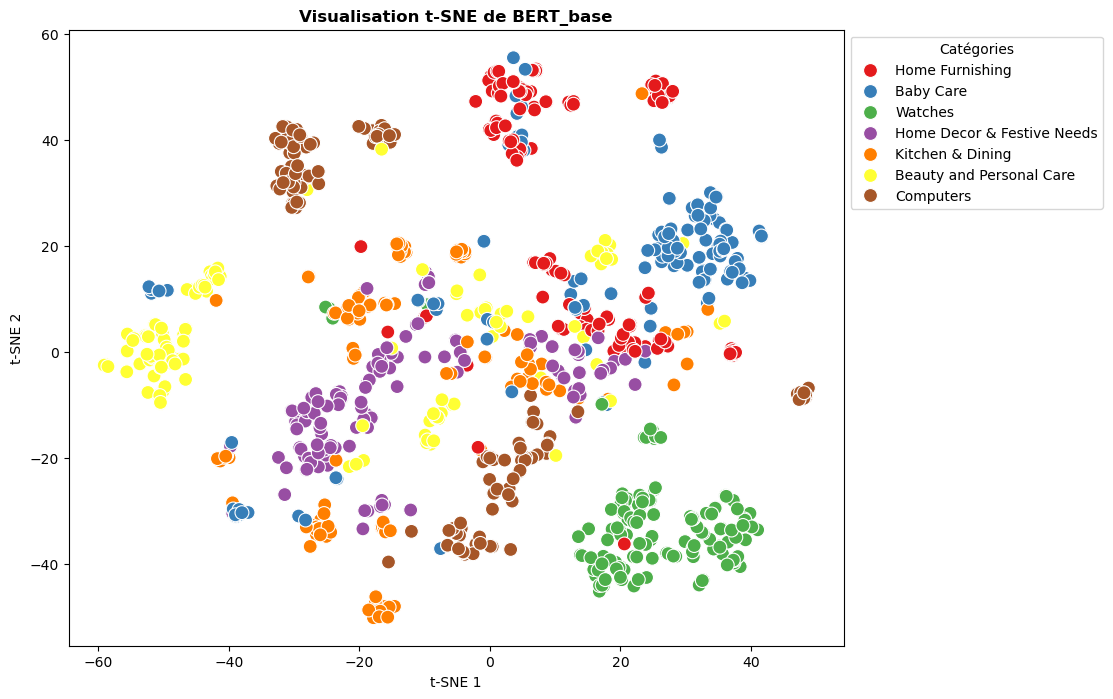

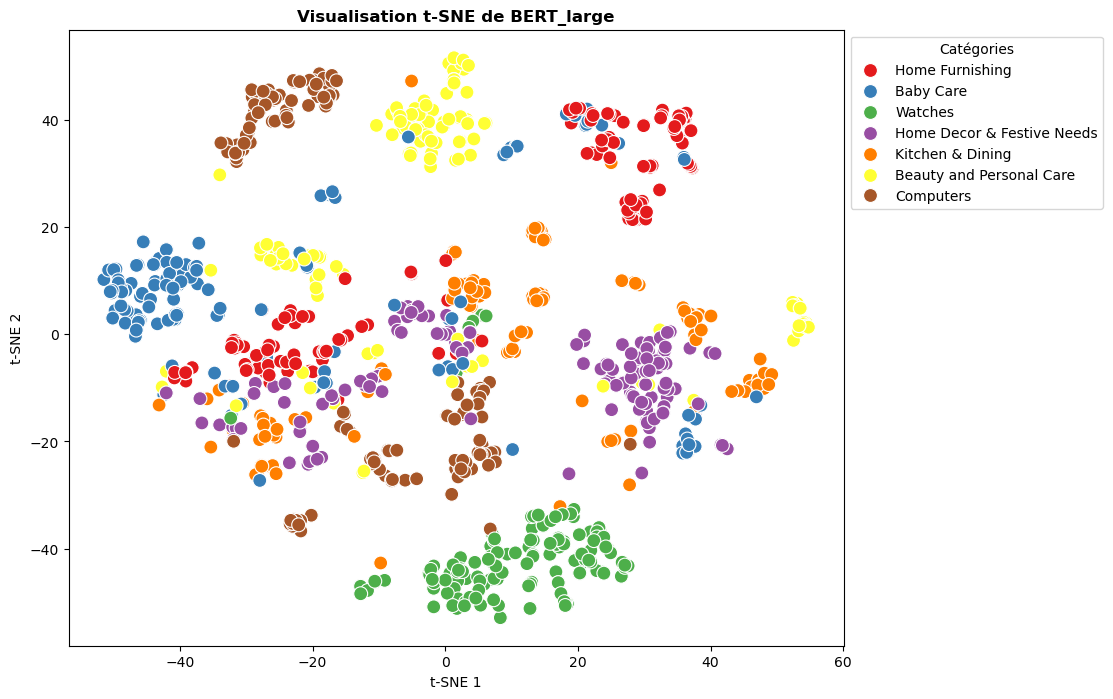

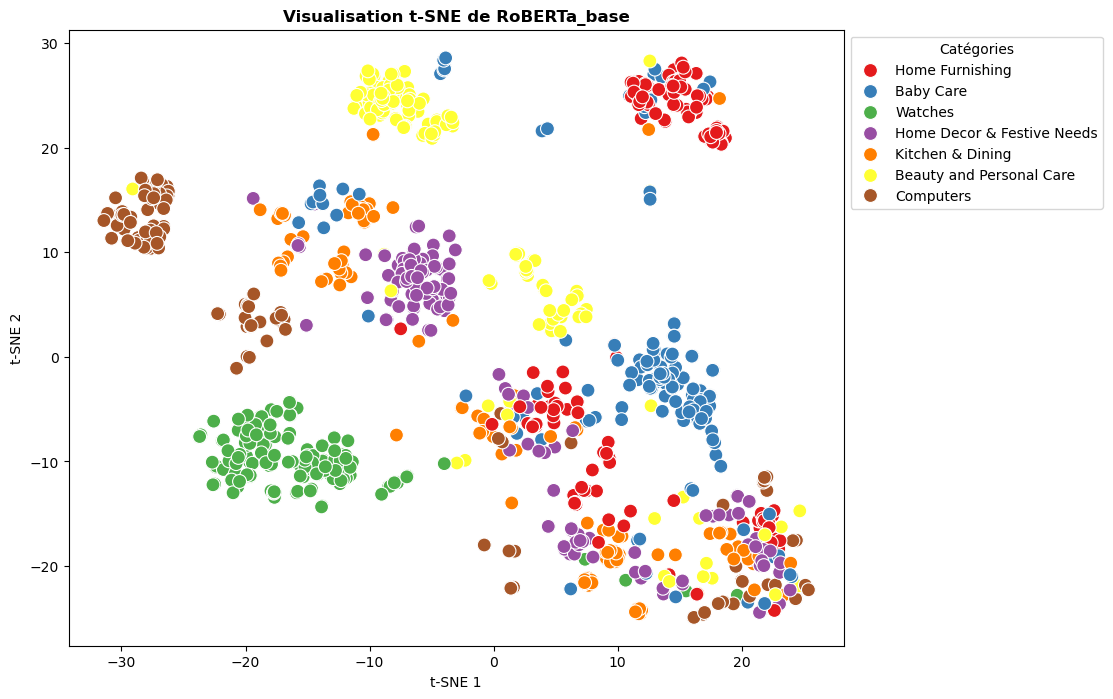

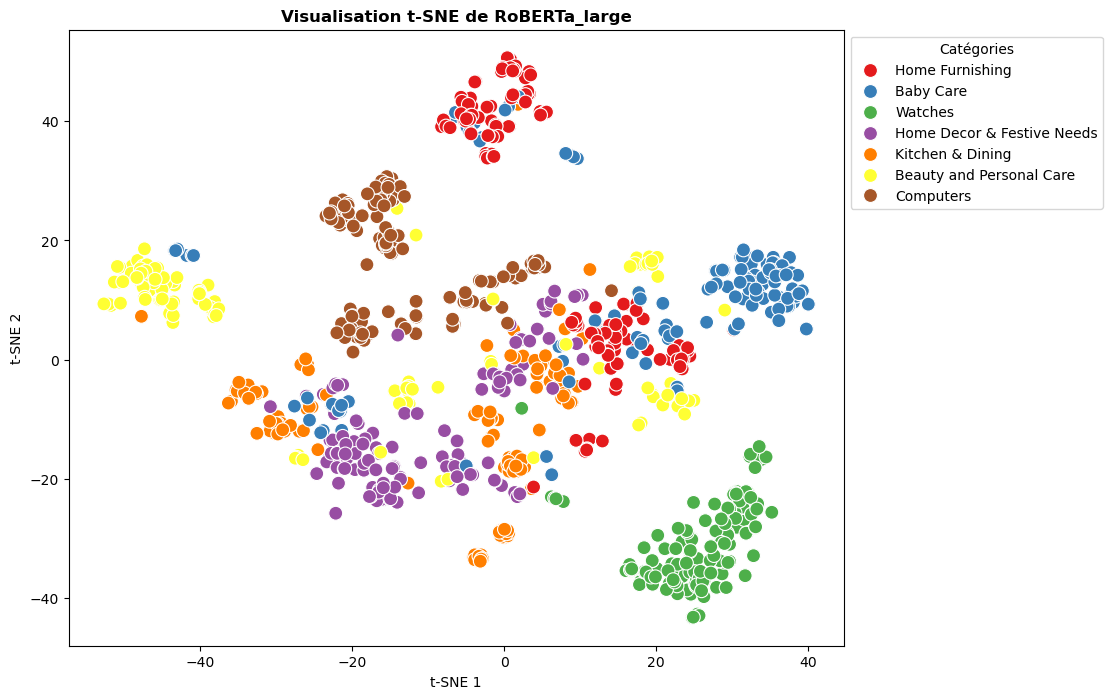

In [6]:
#On peut enfin passer à la visualisation
for model_name in tsne_results.keys():
    plt.figure(figsize=(10, 8))

    sns.scatterplot(x=tsne_results[model_name][:, 0],
                    y=tsne_results[model_name][:, 1],
                    hue=model_dfs[model_name]['categorie_1'],
                    palette='Set1',
                    s=100)

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f'Visualisation t-SNE de {model_name}', weight='bold')
    plt.legend(title='Catégories', bbox_to_anchor=(1, 1), loc='upper left')

    plt.show()
    print()

    #Nettoyage de la mémoire
    gc.collect()

# IV) KMeans <a class='anchor' id='iv'></a>
On entraîne désormais un KMeans par modèle à partir des résultats t-SNE, et on calcule l'ARI pour mesurer la similarité entre les clusters réels et les clusters prédits.

In [42]:
#Un KMeans par modèle, puis on enregistre les clusters prédits
from sklearn.cluster import KMeans

#Dictionnaire pour stocker les labels KMeans
kmeans_labels = {}

for model_name in tsne_results.keys():
    kmeans = KMeans(n_clusters=7, n_init=20, random_state=42)
    kmeans_labels[model_name] = kmeans.fit_predict(tsne_results[model_name])

    print(f'KMeans appliqué pour {model_name} avec 7 clusters.')

KMeans appliqué pour BERT_base avec 7 clusters.
KMeans appliqué pour BERT_large avec 7 clusters.
KMeans appliqué pour RoBERTa_base avec 7 clusters.
KMeans appliqué pour RoBERTa_large avec 7 clusters.


Traitement du modèle : BERT_base

Correspondance des clusters :  {3: 'Baby Care', 5: 'Beauty and Personal Care', 1: 'Computers', 6: 'Home Decor & Festive Needs', 4: 'Home Furnishing', 0: 'Kitchen & Dining', 2: 'Watches'}



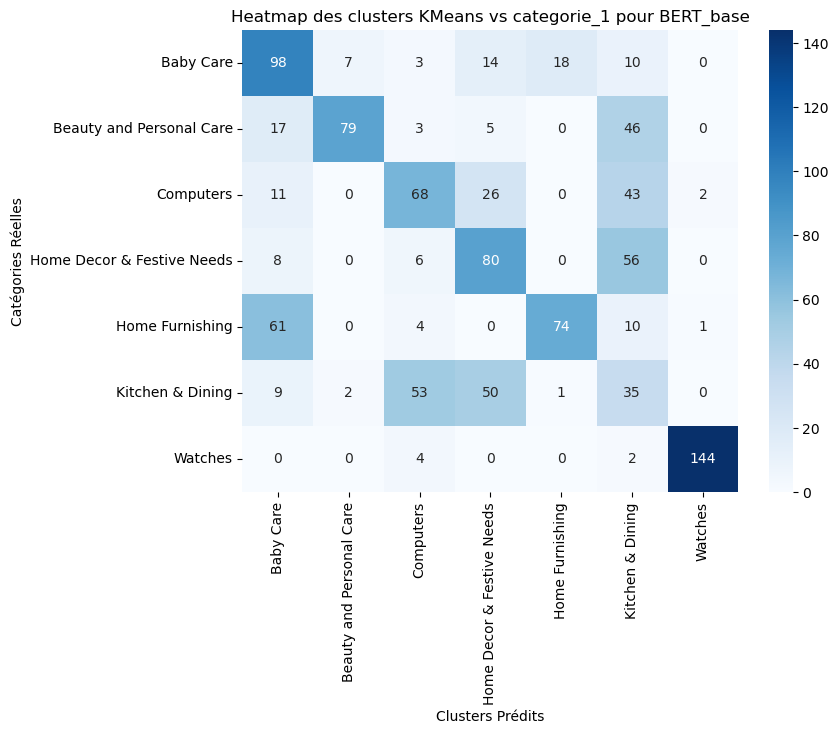


Classification Report pour BERT_base:

                            precision    recall  f1-score   support

                 Baby Care       0.48      0.65      0.55       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.48      0.45      0.47       150
Home Decor & Festive Needs       0.46      0.53      0.49       150
           Home Furnishing       0.80      0.49      0.61       150
          Kitchen & Dining       0.17      0.23      0.20       150
                   Watches       0.98      0.96      0.97       150

                  accuracy                           0.55      1050
                 macro avg       0.61      0.55      0.56      1050
              weighted avg       0.61      0.55      0.56      1050

----- Modèle suivant -----

Traitement du modèle : BERT_large

Correspondance des clusters :  {3: 'Baby Care', 1: 'Beauty and Personal Care', 5: 'Computers', 0: 'Home Decor & Festive Needs', 4: 'Home Furnishin

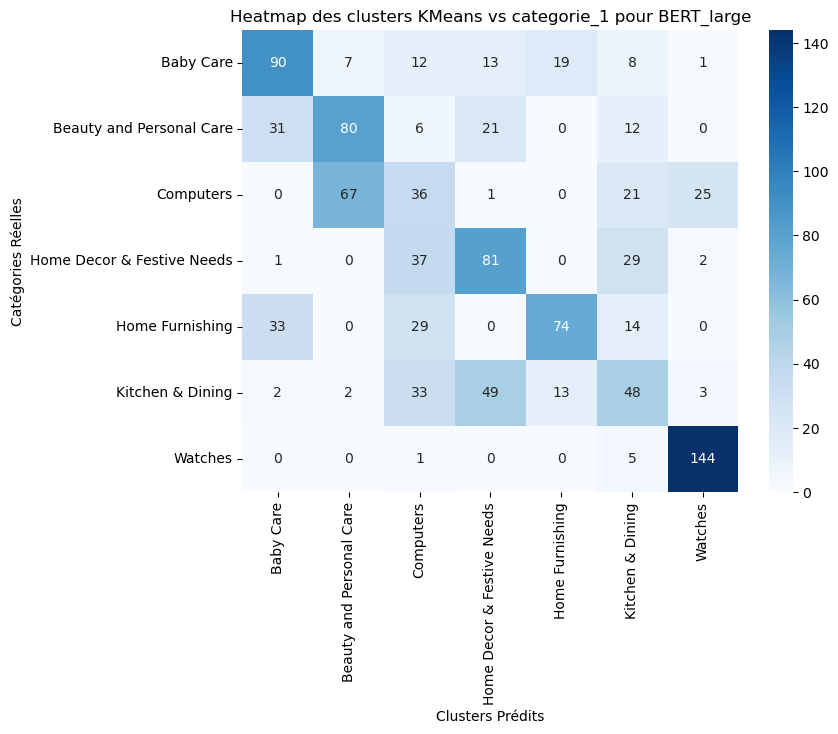


Classification Report pour BERT_large:

                            precision    recall  f1-score   support

                 Baby Care       0.57      0.60      0.59       150
  Beauty and Personal Care       0.51      0.53      0.52       150
                 Computers       0.23      0.24      0.24       150
Home Decor & Festive Needs       0.49      0.54      0.51       150
           Home Furnishing       0.70      0.49      0.58       150
          Kitchen & Dining       0.35      0.32      0.33       150
                   Watches       0.82      0.96      0.89       150

                  accuracy                           0.53      1050
                 macro avg       0.53      0.53      0.52      1050
              weighted avg       0.53      0.53      0.52      1050

----- Modèle suivant -----

Traitement du modèle : RoBERTa_base

Correspondance des clusters :  {6: 'Baby Care', 3: 'Beauty and Personal Care', 5: 'Computers', 4: 'Home Decor & Festive Needs', 0: 'Home Furnis

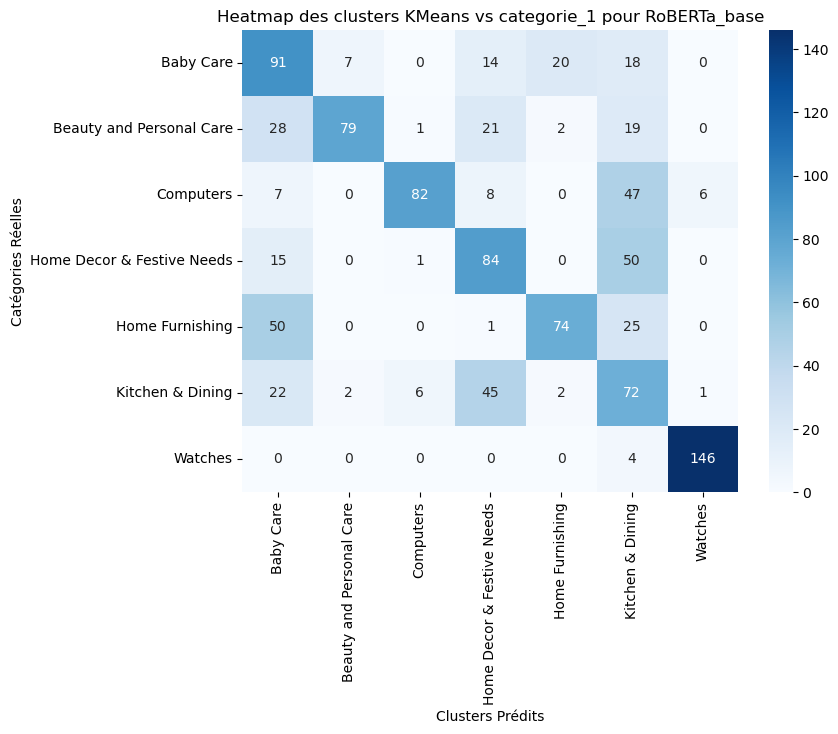


Classification Report pour RoBERTa_base:

                            precision    recall  f1-score   support

                 Baby Care       0.43      0.61      0.50       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.91      0.55      0.68       150
Home Decor & Festive Needs       0.49      0.56      0.52       150
           Home Furnishing       0.76      0.49      0.60       150
          Kitchen & Dining       0.31      0.48      0.37       150
                   Watches       0.95      0.97      0.96       150

                  accuracy                           0.60      1050
                 macro avg       0.68      0.60      0.61      1050
              weighted avg       0.68      0.60      0.61      1050

----- Modèle suivant -----

Traitement du modèle : RoBERTa_large

Correspondance des clusters :  {1: 'Baby Care', 0: 'Beauty and Personal Care', 3: 'Computers', 5: 'Home Decor & Festive Needs', 6: 'Home Fur

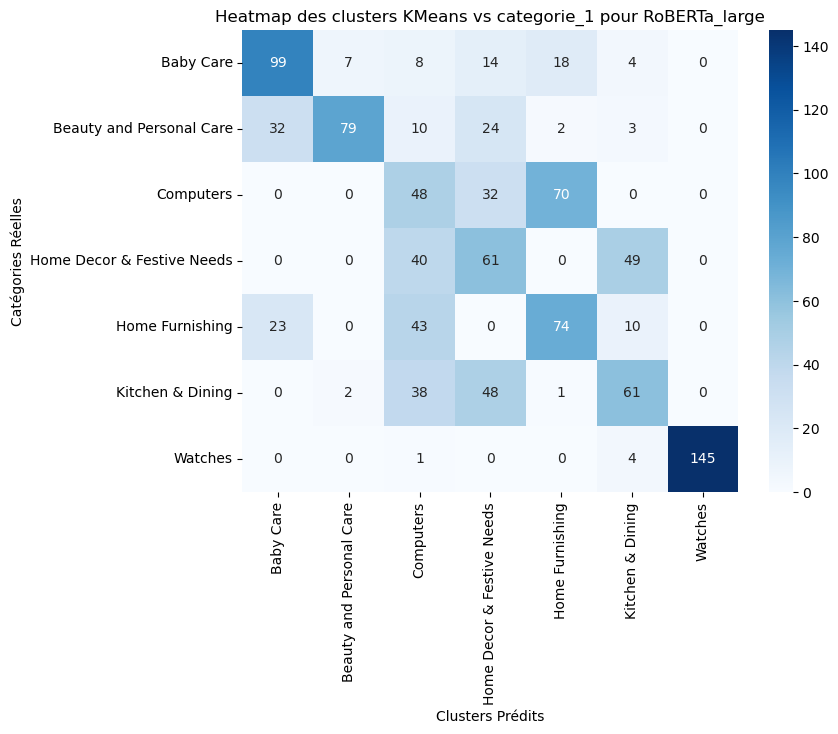


Classification Report pour RoBERTa_large:

                            precision    recall  f1-score   support

                 Baby Care       0.64      0.66      0.65       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.26      0.32      0.28       150
Home Decor & Festive Needs       0.34      0.41      0.37       150
           Home Furnishing       0.45      0.49      0.47       150
          Kitchen & Dining       0.47      0.41      0.43       150
                   Watches       1.00      0.97      0.98       150

                  accuracy                           0.54      1050
                 macro avg       0.58      0.54      0.55      1050
              weighted avg       0.58      0.54      0.55      1050



In [43]:
#On assigne les noms de catégorie_1 aux labels des clusters prédits
#Et on en profite pour les comparer dans une heatmap et un classification_report
from scipy.optimize import linear_sum_assignment #Une autre méthode plus 'simple' aboutit a des clusters vides
from sklearn import metrics

#On définit une fonction pour ajuster les labels
def conf_mat_transform(y_true, y_pred):
    #Matrice de confusion
    conf_mat = pd.crosstab(y_true, y_pred)

    #On convertit en tableau numpy
    cost_matrix = conf_mat.values

    #On applique l'algorithme de Kuhn-Munkres pour obtenir la correspondance optimale
    ligne_ind, col_ind = linear_sum_assignment(-cost_matrix)

    #On créé un dictionnaire de correspondance cluster: catégorie
    noms_categ = np.unique(y_true)
    corresp = {col: noms_categ[ligne] for ligne, col in zip(ligne_ind, col_ind)}
    print('Correspondance des clusters : ', corresp)

    #On map les labels prédits aux catégories réelles en utilisant la correspondance trouvée
    labels = pd.Series(y_pred, name='y_pred').to_frame()
    labels['y_true'] = y_true
    labels['y_pred_transform'] = labels['y_pred'].map(corresp)

    return labels['y_pred_transform']

#Dictionnaire pour stocker les labels transformés
transformed_labels = {}

#Boucle pour traiter tous les modèles
for i, model_name in enumerate(tsne_results.keys()):
    print(f'Traitement du modèle : {model_name}')
    print()
    #On récupère les labels KMeans et les vraies catégories
    kmeans_clusters = kmeans_labels[model_name]
    categories = model_dfs[model_name]['categorie_1'].values

    #On applique la fonction
    transformed_labels[model_name] = conf_mat_transform(categories, kmeans_clusters)
    print() #Un espace avant la suite

    #Matrice de confusion
    conf_mat = pd.crosstab(categories, transformed_labels[model_name])

    #Heatmaps
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=np.unique(transformed_labels[model_name]),
                yticklabels=np.unique(categories))
    plt.title(f'Heatmap des clusters KMeans vs categorie_1 pour {model_name}')
    plt.xlabel('Clusters Prédits')
    plt.ylabel('Catégories Réelles')
    plt.show()
    print()

    #Classification report
    print(f'Classification Report pour {model_name}:')
    print()
    print(metrics.classification_report(categories, transformed_labels[model_name]))

    #Séparation entre chaque modèle (sauf le dernier)
    if i < len(model_names) - 1:
        print('----- Modèle suivant -----\n')

    #Nettoyage de la mémoire
    gc.collect()

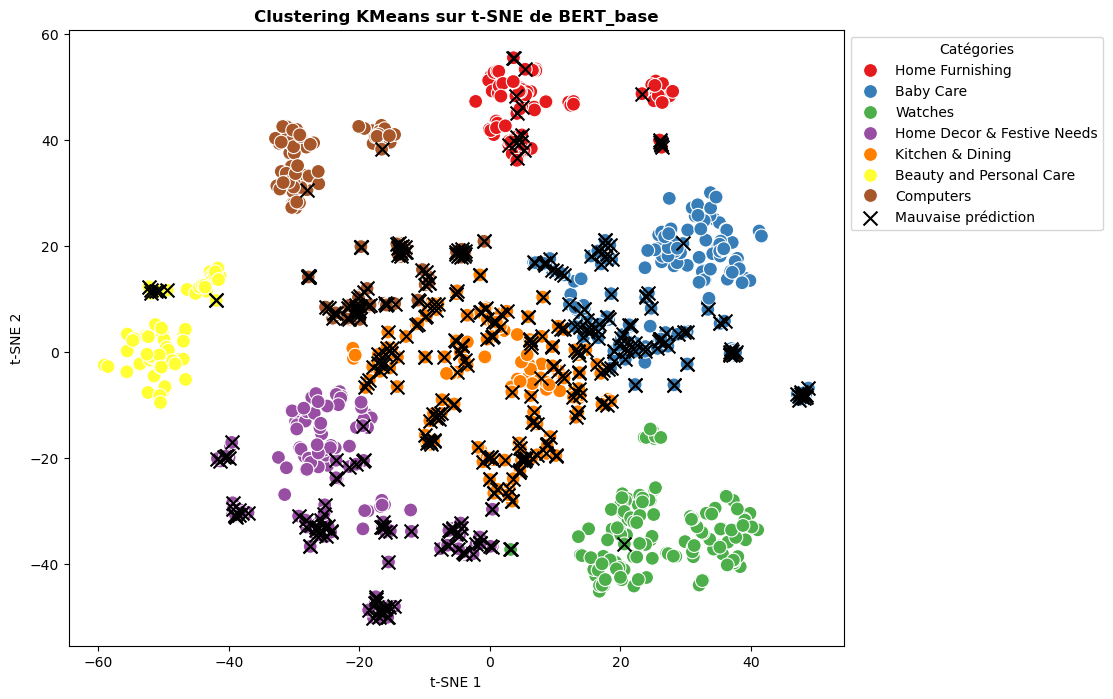

ARI : 0.3408



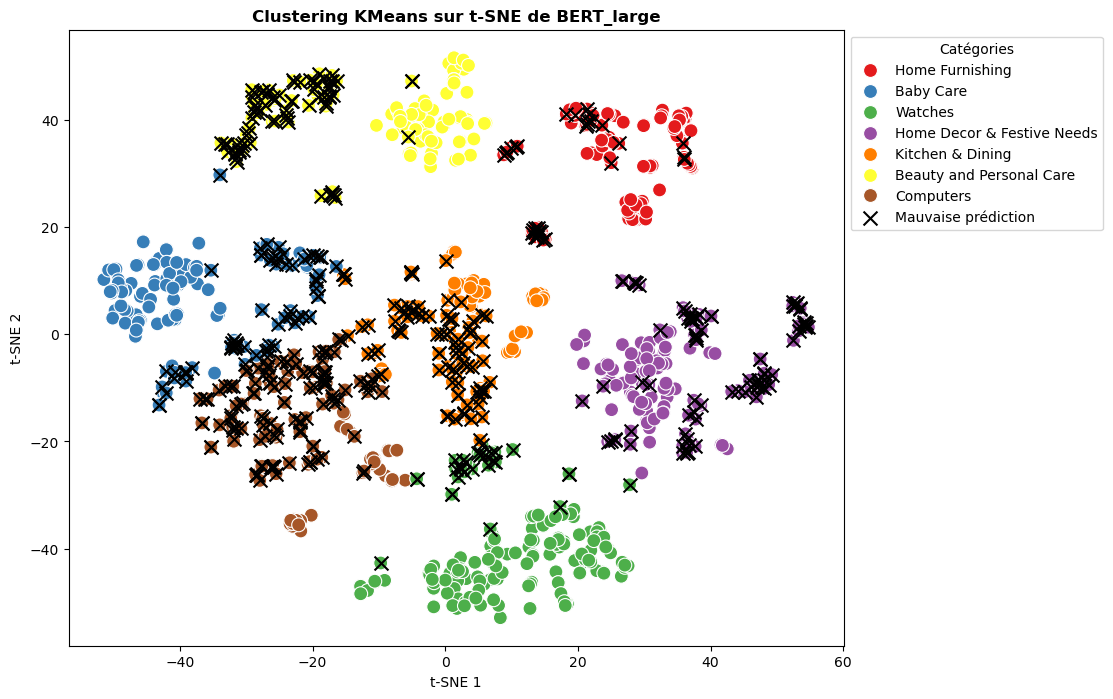

ARI : 0.3188



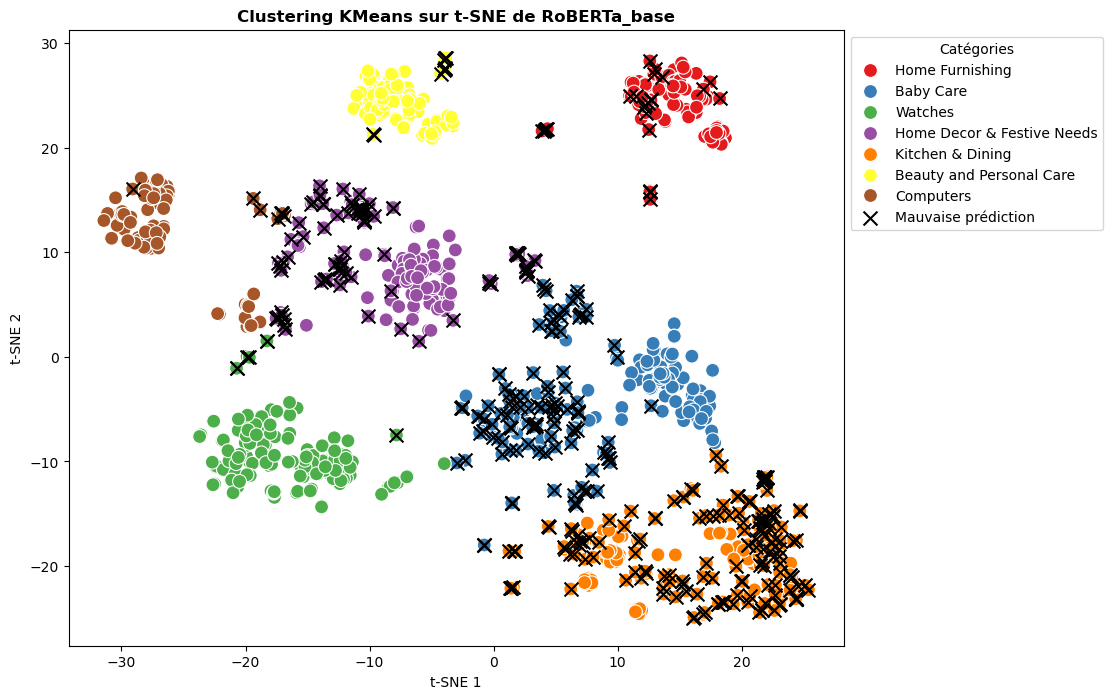

ARI : 0.3325



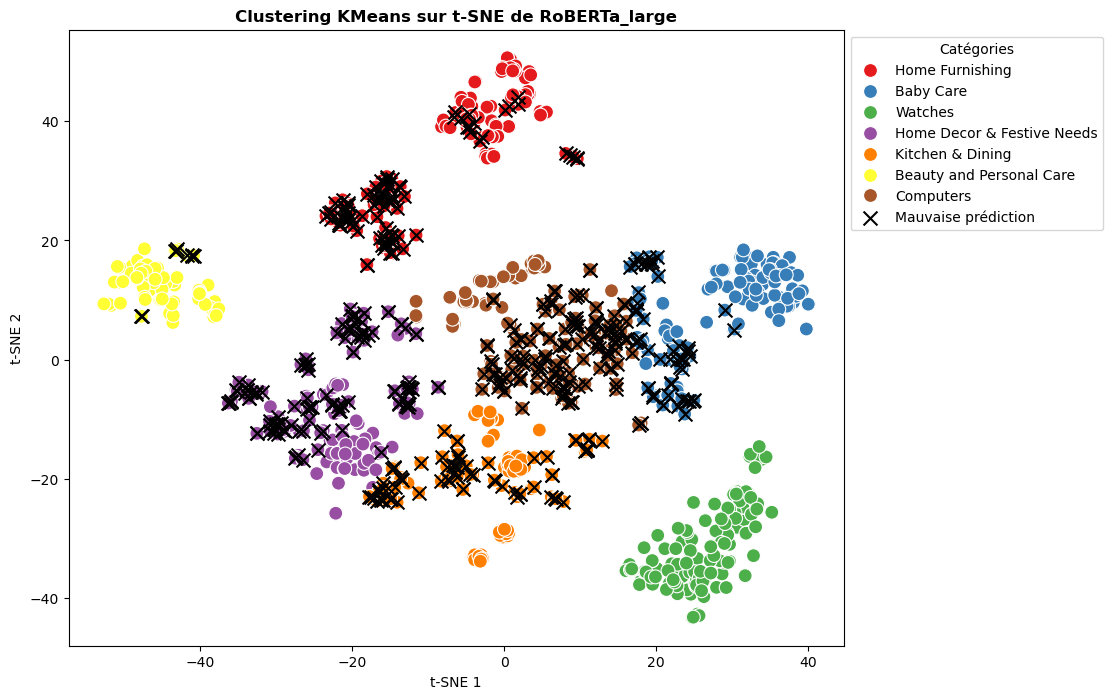

ARI : 0.3410



In [44]:
#On visualise à nouveau, avec score ARI cette fois
#Pour attribuer les mêmes couleurs aux mêmes catégories, on récupère la palette de la visualisation précédente
unique_categories = model_dfs[model_name]['categorie_1'].unique()
palette = sns.color_palette('Set1', n_colors=len(unique_categories))

#Et on associe une couleur à chaque catégorie
color_map = {cat: color for cat, color in zip(unique_categories, palette)}

#Liste pour stocker les scores ARI
scores_ari = []

for model_name in tsne_results.keys():
    plt.figure(figsize=(10, 8))

    sns.scatterplot(x=tsne_results[model_name][:, 0],
                    y=tsne_results[model_name][:, 1],
                    hue=transformed_labels[model_name], #Clusters KMeans
                    palette=color_map, #On applique la palette
                    hue_order=unique_categories, #On force l'ordre de la légende pour correspondre à la première visualisation
                    s=100)

    #On identifie les points mal classés
    mask_misclassified = model_dfs[model_name]['categorie_1'] != transformed_labels[model_name]

    #On ajouter une croix sur ces points
    plt.scatter(tsne_results[model_name][mask_misclassified, 0],  
                tsne_results[model_name][mask_misclassified, 1],  
                color='black', marker='x', s=100, label='Mauvaise prédiction')

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f'Clustering KMeans sur t-SNE de {model_name}', weight='bold')

    plt.legend(title='Catégories', bbox_to_anchor=(1, 1), loc='upper left')

    plt.show()
    
    ari_score = metrics.adjusted_rand_score(model_dfs[model_name]['categorie_1'], transformed_labels[model_name])
    print(f'ARI : {ari_score:.4f}')
    print()

    #On ajoute les informations dans la liste scores_ari
    scores_ari.append({'Model': model_name,
                       'ARI': ari_score,
                       'Clustering': 'KMeans'}) #On précise ici qu'il s'agit des clusters KMeans

    #Nettoyage de la mémoire
    gc.collect()

# V) Test CAH <a class='anchor' id='v'></a>
Par curiosité, je voudrais voir si on arrive à de meilleures prédictions avec une classification hiérarchique.

In [45]:
from sklearn.cluster import AgglomerativeClustering

#Dictionnaire pour stocker les labels CAH
hierarchical_labels = {}

for model_name in tsne_results.keys():
    hierarchical = AgglomerativeClustering(n_clusters=7)
    hierarchical_labels[model_name] = hierarchical.fit_predict(tsne_results[model_name])

    print(f'Clustering hiérarchique appliqué pour {model_name} avec 7 clusters.')

Clustering hiérarchique appliqué pour BERT_base avec 7 clusters.
Clustering hiérarchique appliqué pour BERT_large avec 7 clusters.
Clustering hiérarchique appliqué pour RoBERTa_base avec 7 clusters.
Clustering hiérarchique appliqué pour RoBERTa_large avec 7 clusters.


Traitement du modèle : BERT_base

Correspondance des clusters :  {0: 'Baby Care', 5: 'Beauty and Personal Care', 6: 'Computers', 1: 'Home Decor & Festive Needs', 4: 'Home Furnishing', 2: 'Kitchen & Dining', 3: 'Watches'}



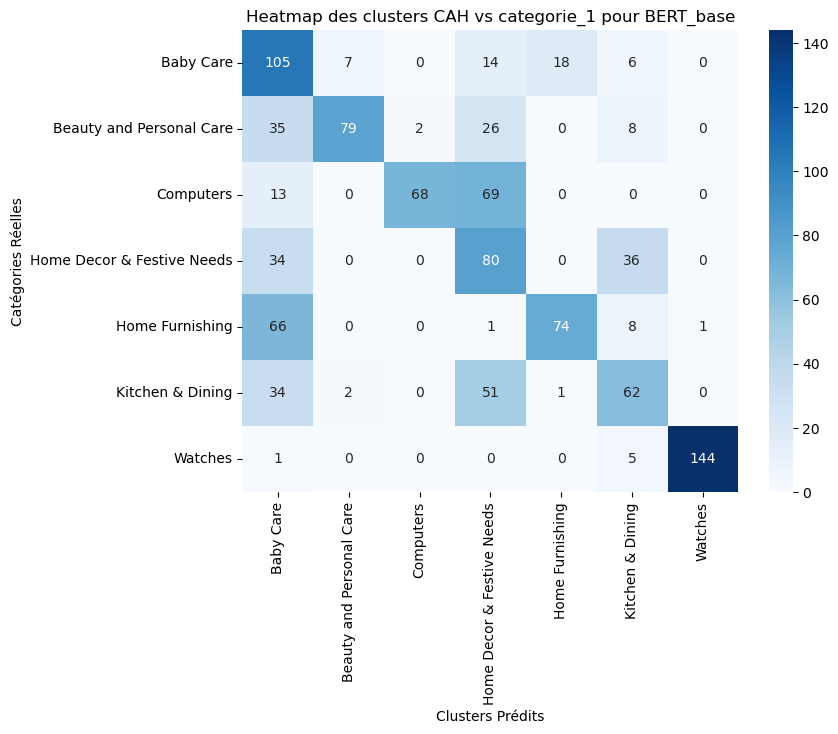


Classification Report pour BERT_base:

                            precision    recall  f1-score   support

                 Baby Care       0.36      0.70      0.48       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.97      0.45      0.62       150
Home Decor & Festive Needs       0.33      0.53      0.41       150
           Home Furnishing       0.80      0.49      0.61       150
          Kitchen & Dining       0.50      0.41      0.45       150
                   Watches       0.99      0.96      0.98       150

                  accuracy                           0.58      1050
                 macro avg       0.69      0.58      0.60      1050
              weighted avg       0.69      0.58      0.60      1050

----- Modèle suivant -----

Traitement du modèle : BERT_large

Correspondance des clusters :  {3: 'Baby Care', 2: 'Beauty and Personal Care', 0: 'Computers', 4: 'Home Decor & Festive Needs', 5: 'Home Furnishin

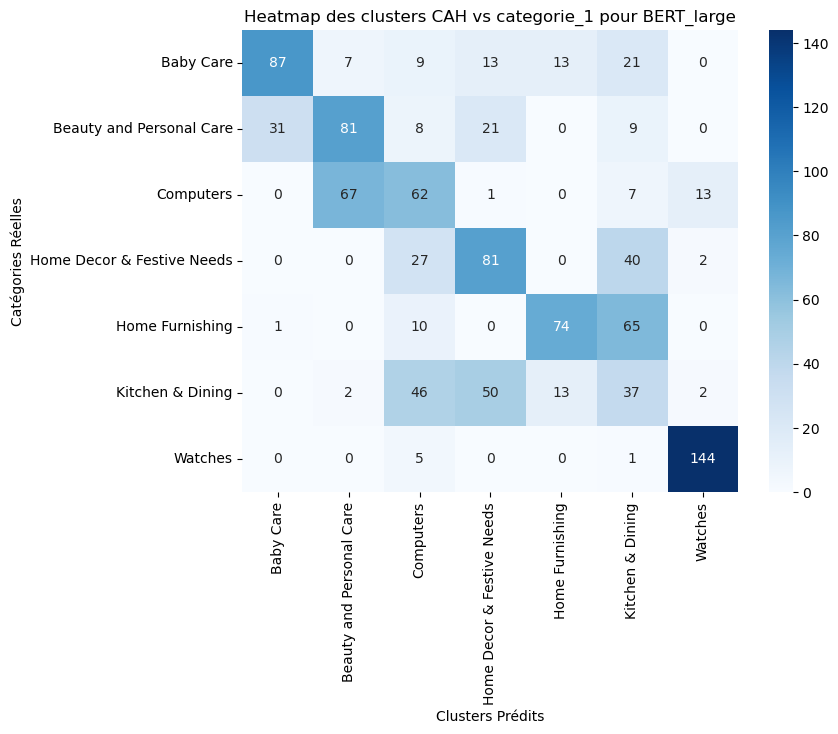


Classification Report pour BERT_large:

                            precision    recall  f1-score   support

                 Baby Care       0.73      0.58      0.65       150
  Beauty and Personal Care       0.52      0.54      0.53       150
                 Computers       0.37      0.41      0.39       150
Home Decor & Festive Needs       0.49      0.54      0.51       150
           Home Furnishing       0.74      0.49      0.59       150
          Kitchen & Dining       0.21      0.25      0.22       150
                   Watches       0.89      0.96      0.93       150

                  accuracy                           0.54      1050
                 macro avg       0.56      0.54      0.55      1050
              weighted avg       0.56      0.54      0.55      1050

----- Modèle suivant -----

Traitement du modèle : RoBERTa_base

Correspondance des clusters :  {1: 'Baby Care', 6: 'Beauty and Personal Care', 2: 'Computers', 4: 'Home Decor & Festive Needs', 5: 'Home Furnis

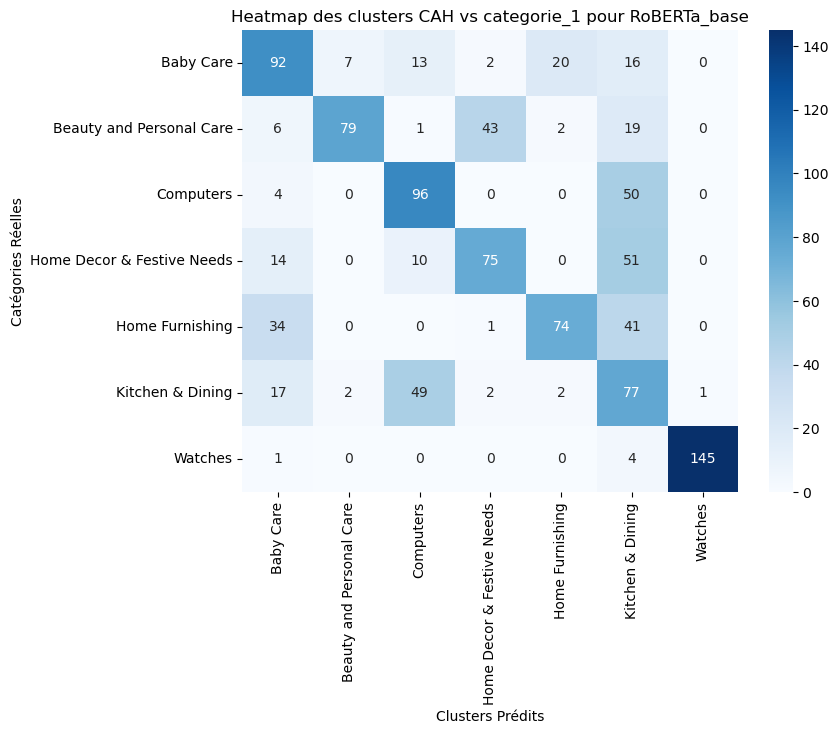


Classification Report pour RoBERTa_base:

                            precision    recall  f1-score   support

                 Baby Care       0.55      0.61      0.58       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.57      0.64      0.60       150
Home Decor & Festive Needs       0.61      0.50      0.55       150
           Home Furnishing       0.76      0.49      0.60       150
          Kitchen & Dining       0.30      0.51      0.38       150
                   Watches       0.99      0.97      0.98       150

                  accuracy                           0.61      1050
                 macro avg       0.67      0.61      0.62      1050
              weighted avg       0.67      0.61      0.62      1050

----- Modèle suivant -----

Traitement du modèle : RoBERTa_large

Correspondance des clusters :  {6: 'Baby Care', 4: 'Beauty and Personal Care', 1: 'Computers', 0: 'Home Decor & Festive Needs', 5: 'Home Fur

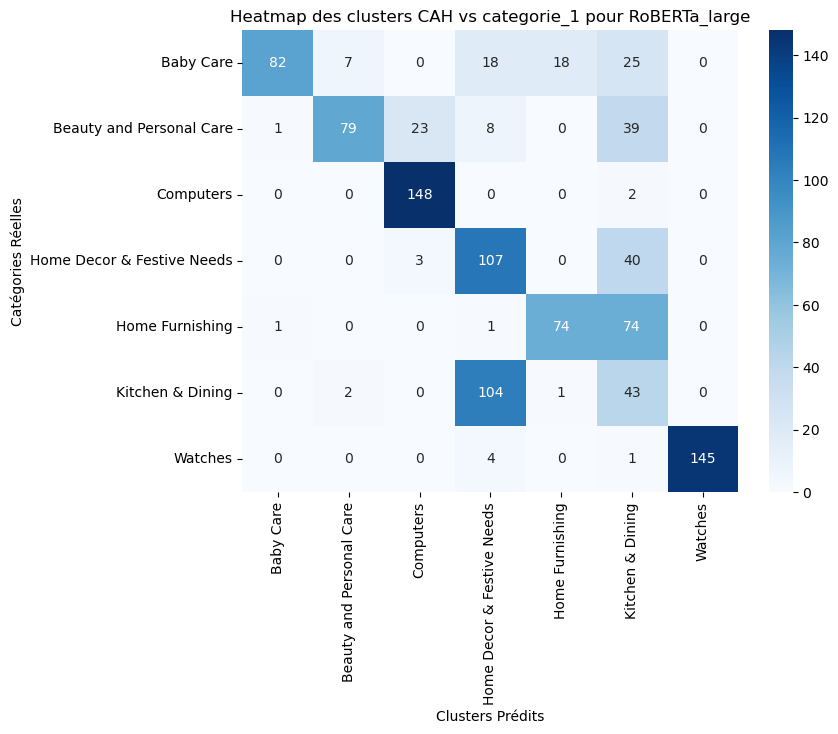


Classification Report pour RoBERTa_large:

                            precision    recall  f1-score   support

                 Baby Care       0.98      0.55      0.70       150
  Beauty and Personal Care       0.90      0.53      0.66       150
                 Computers       0.85      0.99      0.91       150
Home Decor & Festive Needs       0.44      0.71      0.55       150
           Home Furnishing       0.80      0.49      0.61       150
          Kitchen & Dining       0.19      0.29      0.23       150
                   Watches       1.00      0.97      0.98       150

                  accuracy                           0.65      1050
                 macro avg       0.74      0.65      0.66      1050
              weighted avg       0.74      0.65      0.66      1050



In [46]:
#On applique la même fonction que tout à l'heure pour assigner les noms de catégorie_1 aux labels des clusters prédits
#Et on en profite toujours pour les comparer dans une heatmap et un classification_report
#Dictionnaire pour stocker les labels transformés
transformed_labels = {}

#Boucle pour traiter tous les modèles
for i, model_name in enumerate(tsne_results.keys()):
    print(f'Traitement du modèle : {model_name}')
    print()
    #On récupère les labels CAH et les vraies catégories
    hierarchical_clusters = hierarchical_labels[model_name]
    categories = model_dfs[model_name]['categorie_1'].values

    #On applique la fonction
    transformed_labels[model_name] = conf_mat_transform(categories, hierarchical_clusters)
    print() #Un espace avant la suite

    #Matrice de confusion
    conf_mat = pd.crosstab(categories, transformed_labels[model_name])

    #Heatmaps
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=np.unique(transformed_labels[model_name]),
                yticklabels=np.unique(categories))
    plt.title(f'Heatmap des clusters CAH vs categorie_1 pour {model_name}')
    plt.xlabel('Clusters Prédits')
    plt.ylabel('Catégories Réelles')
    plt.show()
    print()

    #Classification report
    print(f'Classification Report pour {model_name}:')
    print()
    print(metrics.classification_report(categories, transformed_labels[model_name]))

    #Séparation entre chaque modèle (sauf le dernier)
    if i < len(model_names) - 1:
        print('----- Modèle suivant -----\n')

    #Nettoyage de la mémoire
    gc.collect()

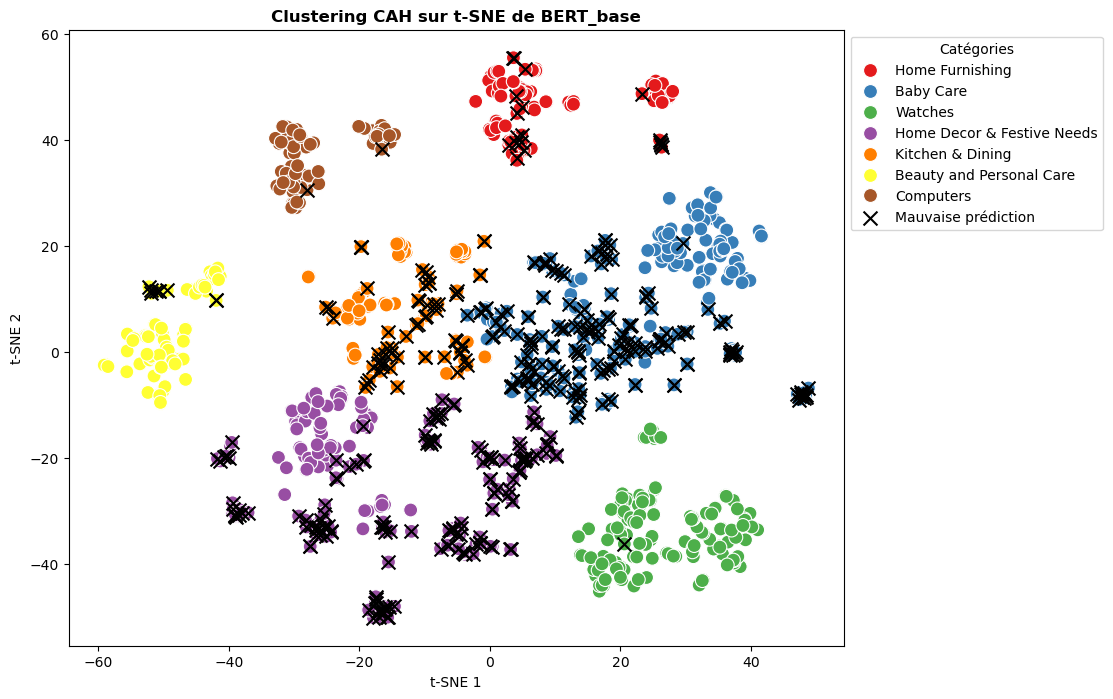

ARI : 0.3176



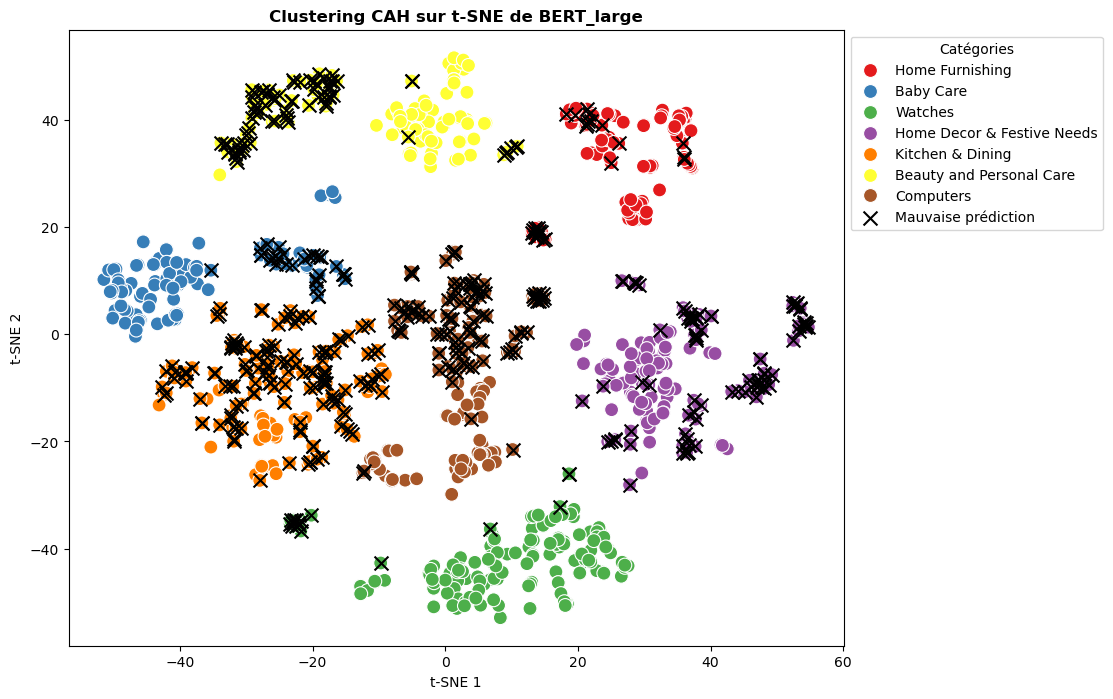

ARI : 0.3437



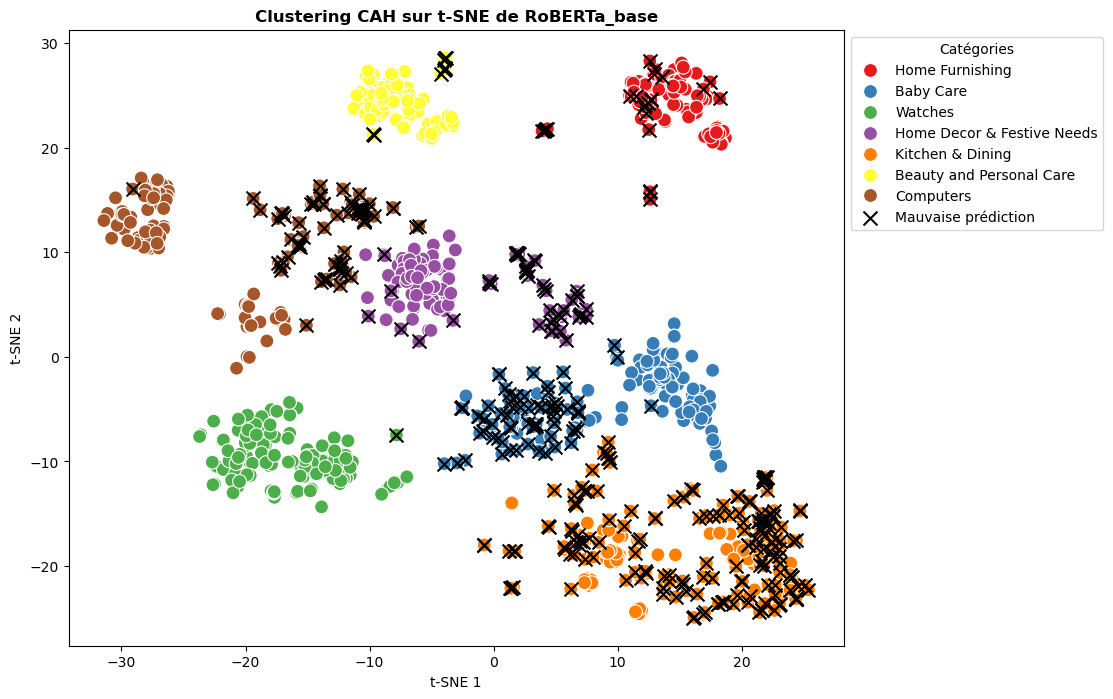

ARI : 0.3541



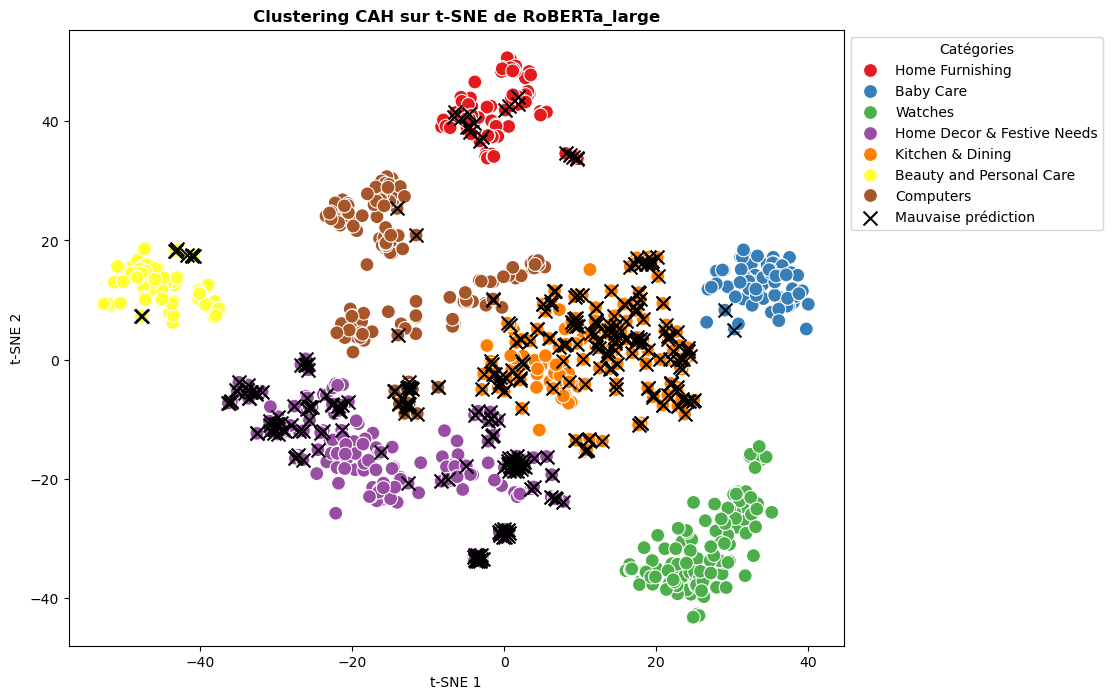

ARI : 0.4812



In [47]:
#On visualise à nouveau, encore une fois avec le score ARI
for model_name in tsne_results.keys():
    plt.figure(figsize=(10, 8))

    sns.scatterplot(x=tsne_results[model_name][:, 0],
                    y=tsne_results[model_name][:, 1],
                    hue=transformed_labels[model_name], #Couleurs selon les clusters CAH
                    palette=color_map, #On applique la palette
                    hue_order=unique_categories, #On force l'ordre de la légende pour correspondre à la première visualisation
                    s=100)

    #On identifie les points mal classés
    mask_misclassified = model_dfs[model_name]['categorie_1'] != transformed_labels[model_name]

    #On ajouter une croix sur ces points
    plt.scatter(tsne_results[model_name][mask_misclassified, 0],  
                tsne_results[model_name][mask_misclassified, 1],  
                color='black', marker='x', s=100, label='Mauvaise prédiction')

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title(f'Clustering CAH sur t-SNE de {model_name}', weight='bold')

    plt.legend(title='Catégories', bbox_to_anchor=(1, 1), loc='upper left')

    plt.show()
    ari_score = metrics.adjusted_rand_score(model_dfs[model_name]['categorie_1'], transformed_labels[model_name])
    print(f'ARI : {ari_score:.4f}')
    print()

    #On ajoute les informations dans la liste scores_ari
    scores_ari.append({'Model': model_name,
                       'ARI': ari_score,
                       'Clustering': 'CAH'}) #On précise ici qu'il s'agit des clusters CAH

    #Nettoyage de la mémoire
    gc.collect()

# VI) Synthèse des résultats <a class='anchor' id='vi'></a>
Encore un peu de visualisation pour faire le point.

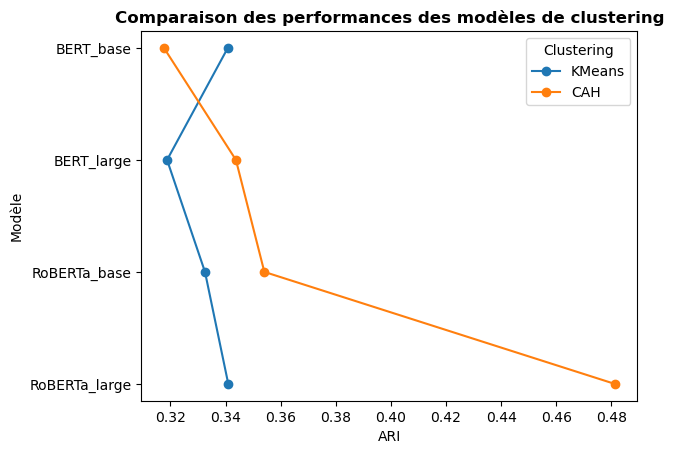

In [48]:
#On transforme notre liste de scroes ARI en df
df_ari = pd.DataFrame(scores_ari)

#On trace les lignes entre les points du même cluster
for cluster in df_ari['Clustering'].unique():
    subset = df_ari[df_ari['Clustering'] == cluster]
    plt.plot(subset['ARI'], subset['Model'], marker='o', label=cluster)

plt.title('Comparaison des performances des modèles de clustering', weight='bold')
plt.xlabel('ARI')
plt.ylabel('Modèle')
plt.legend(title='Clustering')

#On inverse l'axe des y
plt.gca().invert_yaxis()
plt.show()

# Conclusion <a class='anchor' id='conclusion'></a>
On a bien fait de tester une autre méthode de clustering, RoBERTa Large présente de bien meilleurs résultats que BERT avec le CAH.